# All that is needed to train the classifier at present

In [1]:
### Required packages needed for code to run on the notebook ####
!export WANDB_API_KEY="eb026e4498f37dd743e94d922730445ef763a471"
!pip install wandb
!pip install nvidia-dali-cuda110
!pip install lru-dict
!pip install efficientnet_pytorch
!pip install pytorch_lightning

  Obtaining dependency information for wandb from https://files.pythonhosted.org/packages/1c/5e/0362fa88679852c7fd3ac85ee5bd949426c4a51a61379010d4089be6d7ac/wandb-0.15.12-py3-none-any.whl.metadata
  Obtaining dependency information for GitPython!=3.1.29,>=1.0.0 from https://files.pythonhosted.org/packages/8a/7e/20f7e45878b5aed34320fbeeae8f78acc806e7bd708d00b1c6e64b016f5b/GitPython-3.1.37-py3-none-any.whl.metadata
  Obtaining dependency information for sentry-sdk>=1.0.0 from https://files.pythonhosted.org/packages/63/25/d22e1e152e4eac10d39d9132d7b5f1ea4bdfa0b9a1d65fc606a7b90aeefb/sentry_sdk-1.32.0-py2.py3-none-any.whl.metadata
  Preparing metadata (setup.py) ... done
  Obtaining dependency information for setproctitle from https://files.pythonhosted.org/packages/79/e7/54b36be02aee8ad573be68f6f46fd62838735c2f007b22df50eb5e13a20d/setproctitle-1.3.3-cp310-cp310-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Using cached gitdb-4.0.10-py3-non

  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=0bd99447ce605be36e4842e25b48c4b6332fa339b52741bf944ddabff042e6f4
  Stored in directory: /home/ec2-user/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch
  Obtaining dependency information for pytorch_lightning from https://files.pythonhosted.org/packages/98/09/9b2eab7833494e7c82f70c9b2f8e907d38231f4535704e3045a8a4960c8e/pytorch_lightning-2.1.0-py3-none-any.whl.metadata
  Obtaining dependency information for torchmetrics>=0.7.0 from https://files.pythonhosted.org/packages/a3/88/cc27059747ddecff744826e38014822023cbfff4ca079a6ee9a96602dd0b/torchmetrics-1.2.0-py3-none-any.whl.metadata
  Obtaining dependency information for lightning-utilities>=0.8.0 from https://files.pythonhosted.org/packages/46/ee/8641eeb6a062f383b7d6875604e1f3f83bd2c93a0b4dbcabd3150b32de6e/lightning_utilities-0.9.0-py3-none-any.whl.metadata
 

In [1]:

import wandb
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger

from sys import platform
from models.efficientnet import EfficientNetV2

# Resnet is Resnet 18 (18 Residual SKip Blocks, vs 50)
from models.resnet import ResNet, ResNet50

# These libraries hold dataset information
from dataset import DataloopDataset,DataloopDatasetClean,NonDataloopDatasetSubset

# This is the Trainer Library
from training_wheels import TrainingWheels

# Library that allows for to alter "raw" images. Allows for random rotation, flipping, and adding "noise"
from augmentation import Augmentation

if platform == "linux":
    from training_wheels_dali import TrainingWheelsDALI

from datetime import datetime
from PIL import Image
import matplotlib.pyplot as plt

from argparse import ArgumentParser
import os

In [2]:
# This stores a variety of parameters that are used in dataset, augmentation, and Training information

hparams = {
    'dataset_dir':"dataloop",
    'model':"resnet18",
    'use_wandb':True,
    'enable_random_cropping':False,
    'batch_size':2,
    'num_gpus':1,
    'downscaling_width':1224,
    'downscaling_height':1632,
    'max_epochs':4,
    'accelerator':None,
    'devices':None,
    'use_dali':False,
    'center_crop':448,
    'enable_vertical_mirroring':False,
    'enable_horizontal_mirroring':True,
    'random_rotation_angle':15,
    'noise_amount':0,
    'resume_from_checkpoint':None,
    'enable_image_logging':True,
    'lr':0.0001
}

In [3]:
# datetime object containing current date and time
now = datetime.now()
dt_string = now.strftime("%m/%d/%Y %H:%M")

In [ ]:
%%time
dataset_dir = hparams['dataset_dir']

# This loads the augmentation object (see the keywords and how they are used inside )
augmentation = Augmentation(enable_random_cropping=hparams['enable_random_cropping'],
                            enable_vertical_mirroring=hparams['enable_vertical_mirroring'],
                            enable_horizontal_mirroring=hparams['enable_horizontal_mirroring'],
                            random_rotation_angle=hparams['random_rotation_angle'],
                            noise_amount=hparams['noise_amount'],
                            downscaling_width=hparams['downscaling_width'],
                            downscaling_height=hparams['downscaling_height'])


# Dataset_dir loads the clean data, dataset_dir_2 loads (at random the dirty cars are pulled in)
dataset = DataloopDatasetClean(dataset_dir=dataset_dir,dataset_dir_2='Output/dirt_heavy/',
                          train=True,
                          augmentation=augmentation)

In [ ]:
batch_size = hparams['batch_size']
logger = WandbLogger(project="car-condition-classifier",log_model='all',name=dt_string) if hparams['use_wandb'] else None
if hparams['model'] == "efficientnet":
    model = EfficientNetV2()
elif hparams['model'] == "resnet18":
    model = ResNet()
elif hparams['model'] == "resnet50":
    model = ResNet50()
else:
    assert False, "Unknown model: {}".format(hparams['model'])
accelerator = "gpu" if hparams['num_gpus'] > 0 else None

In [ ]:
if hparams['use_dali']:
    training_wheels = TrainingWheelsDALI(model=model,
                                         dataset=dataset,
                                         batch_size=batch_size,
                                         lr=hparams['lr'])
    if 'PL_TRAINER_GPUS' in os.environ:
        os.environ.pop('PL_TRAINER_GPUS')
    trainer = pl.Trainer(max_epochs=int(hparams['max_epochs']), logger=logger, accelerator=accelerator,
                         devices=max(hparams['num_gpus'], 1))
else:
    training_wheels = TrainingWheels(model=model,
                                     dataset=dataset,
                                     batch_size=batch_size,
                                     augmentation=augmentation,
                                     lr=hparams['lr'],
                                     enable_image_logging=hparams['enable_image_logging'],
                                     validation_set_size=0.2)
    trainer = pl.Trainer(max_epochs=int(hparams['max_epochs']), logger=logger, accelerator=accelerator,
                         devices=max(hparams['num_gpus'], 1))

In [11]:
trainer.fit(training_wheels, ckpt_path=hparams['resume_from_checkpoint'])

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ········


wandb: Appending key for api.wandb.ai to your netrc file: /home/ec2-user/.netrc


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params
---------------------------------
0 | model | ResNet | 11.2 M
---------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.710    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=4` reached.


# Extra Analysis Code

In [27]:
training_wheels.validation_data.indices[153]

691

In [30]:
d_file = dataset.files[training_wheels.validation_data.indices[164]]

'dataloop/items/IcDpwoMB-YxIUEnR40Kh_8.jpg'

dataloop/items/4ft8EYQBUMhyNhiEmMY8_5.jpg


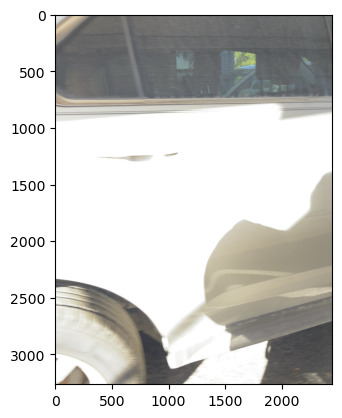

In [35]:
d_file = dataset.files[training_wheels.validation_data.indices[322]]
print(d_file)
img = Image.open(d_file)

plt.imshow(img)

In [ ]:
trainer.val_dataloaders

In [5]:
len(dataset)

3702

In [12]:
from torchvision.transforms import transforms
inv_norm_2 = transforms.Compose([transforms.Normalize(mean=[0., 0., 0.],
                                                                std=[1 / 0.229, 1 / 0.224, 1 / 0.225]),
                                           transforms.Normalize(mean=[-0.485, -0.456, -0.406],
                                                                std=[1., 1., 1.]),
                                           ])

In [118]:
img = Image.open('Output/dirt_heavy/siouMIgB_PhRbcpauroI_5.jpg').rotate(-90).crop([395,0,2850,2450])

In [127]:
tform = torchvision.transforms.ToPILImage()

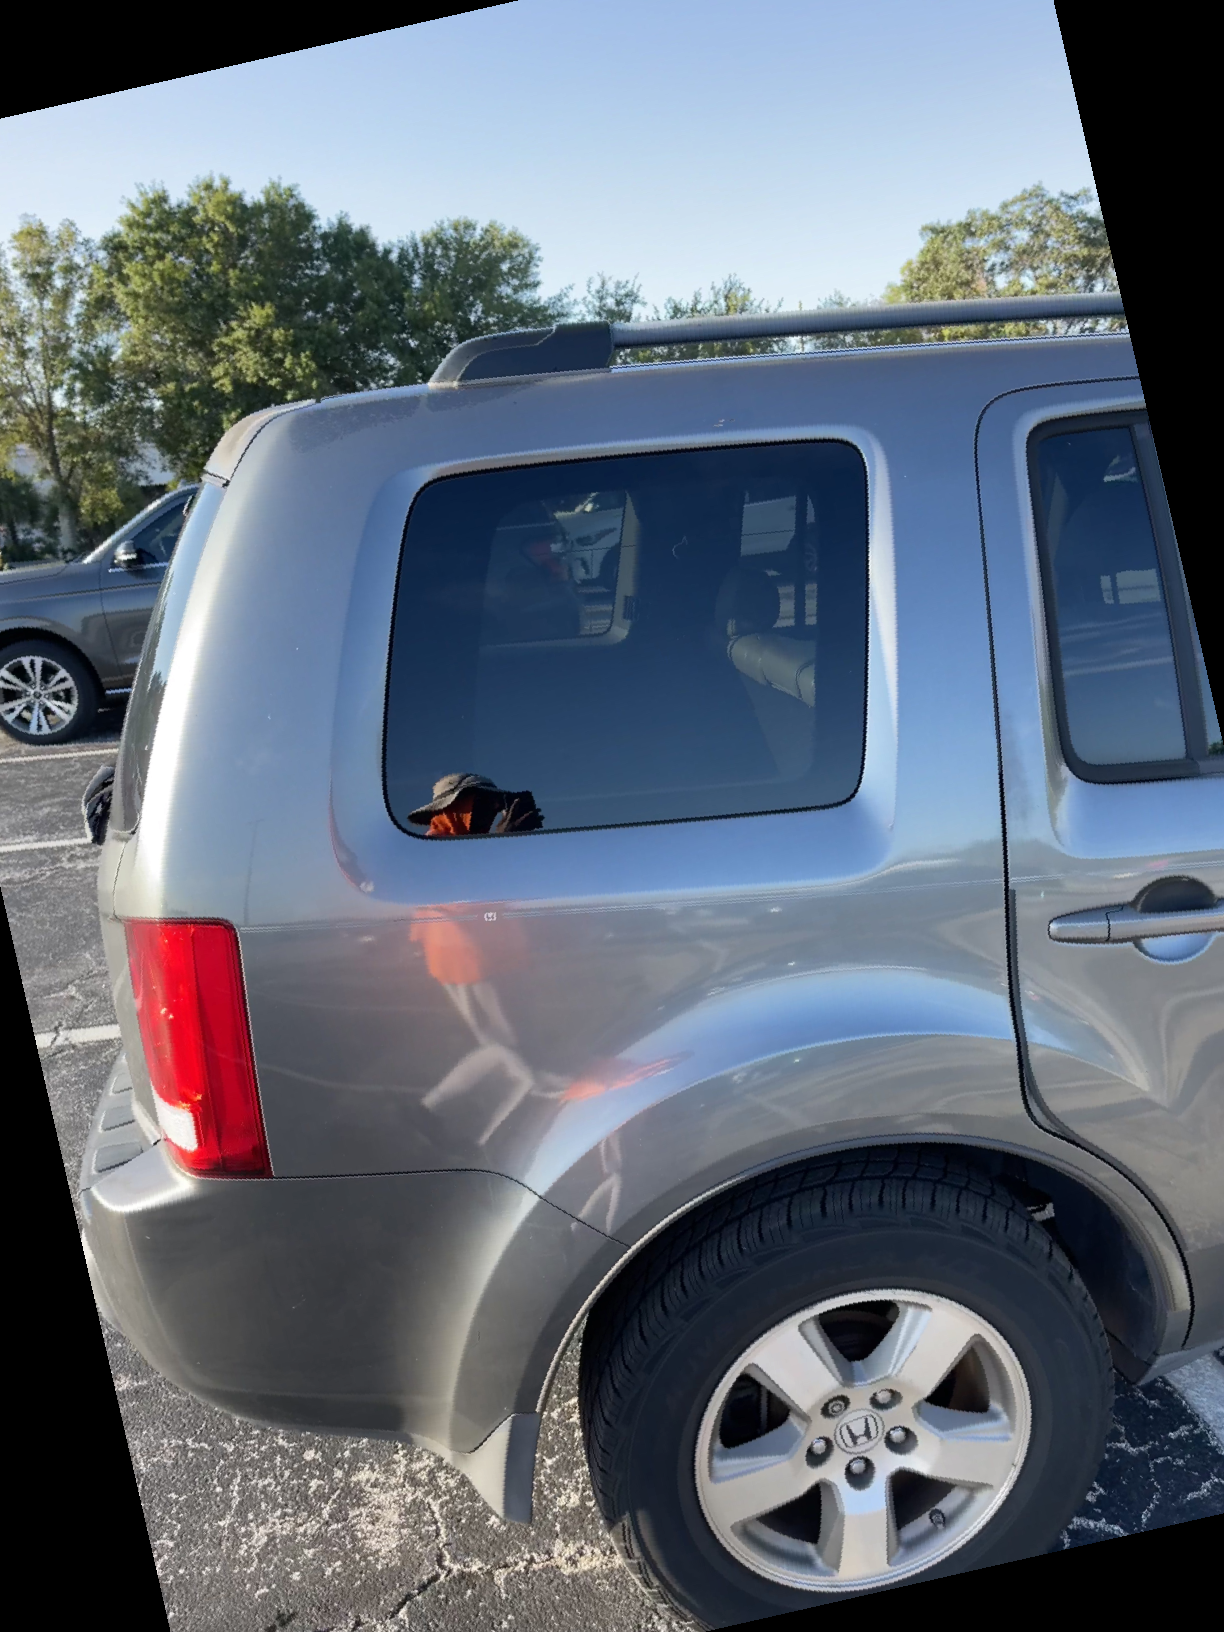

In [128]:
tform(inv_norm(vali[0][0]))

In [138]:
img = Image.open(dataset.files[2019])

plt.imshow(img)

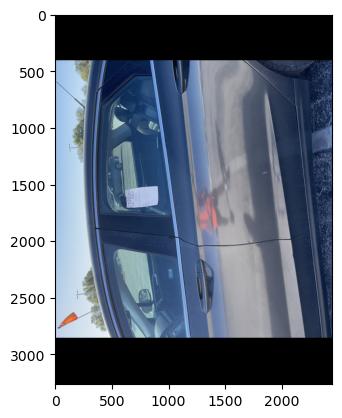

In [39]:
plt.imshow(img.rotate(270))

In [ ]:
dataset.files[3138]

In [ ]:
training_wheels

In [137]:
training_wheels.validation_data.indices[53]

2019

In [72]:
training_wheels.validation_data.numpy()

AttributeError: 'Subset' object has no attribute 'numpy'

In [132]:
training_wheels.validation_data[53][0]

tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

        [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         ...,
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

        [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
         [-1.8044, -1.8044, -1.8044,  ..., -1

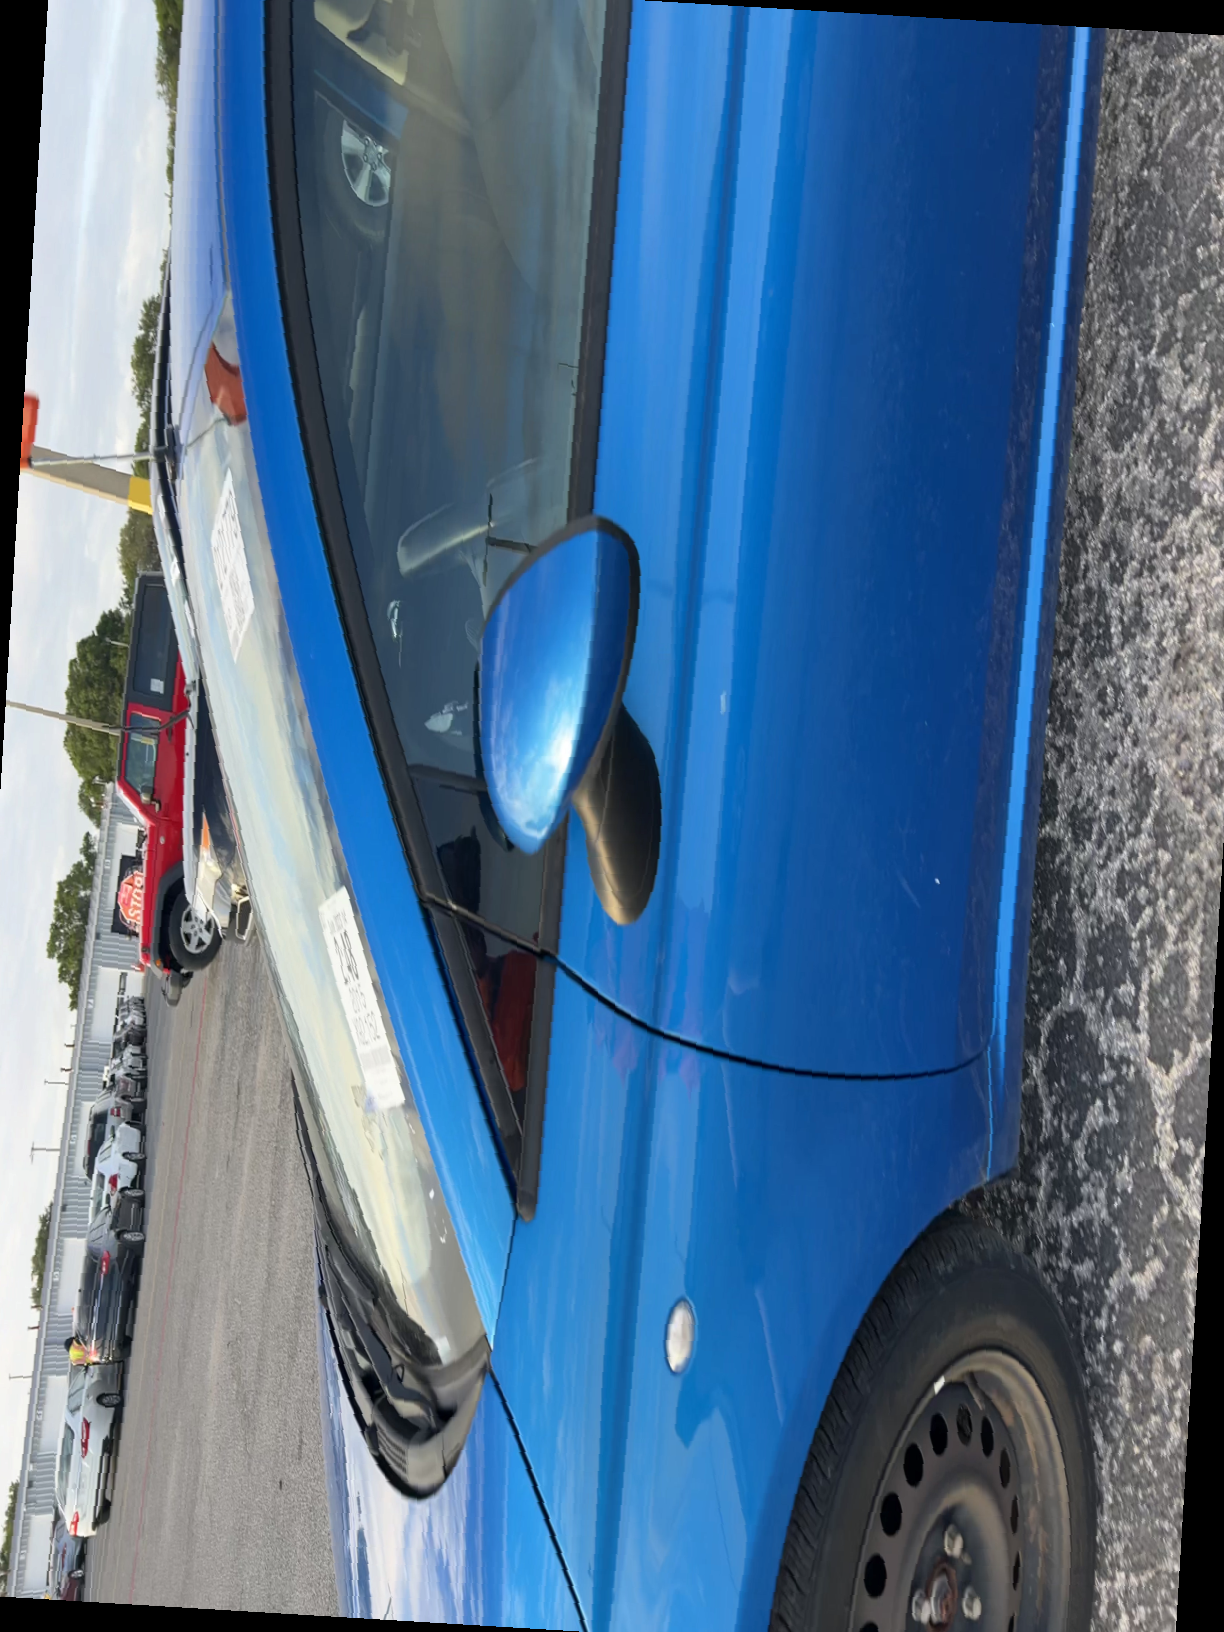

In [133]:
tform(inv_norm(training_wheels.validation_data[53][0]))

In [82]:
for j in range(len(training_wheels.validation_data[0])):
    for k in range(len(training_wheels.validation_data[0][j])):
        for l in range(len(training_wheels.validation_data[0][j][k])):
            for m in range(len(training_wheels.validation_data[0][j][k][l])):
                if(training_wheels.validation_data[0][j][k][l][m].numpy()==training_wheels.validation_data[0][j][k][l][m].numpy()):
                    pass
                else:
                    print(j,k,l,m)
                    break


0 0 0 3
0 0 1 28


KeyboardInterrupt: 

In [81]:
training_wheels.validation_data[0][j][k][l]

tensor([-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179])

In [38]:
import torchvision.utils as vutils

# Load the image tensor
image = torch.load("image.pt")

NameError: name 'torch' is not defined

In [33]:
type(dataset[0][0])

torch.Tensor

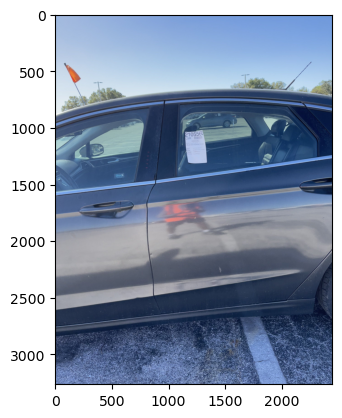

In [36]:
plt.imshow(img.convert("RGB"))

In [27]:
wandb.Image(inv_norm_2(dataset[0][0]))

In [ ]:
## Important Code currently

In [9]:
%%time
dataset_dir = hparams['dataset_dir']
batch_size = hparams['batch_size']
logger = WandbLogger(project="car-condition-classifier",log_model='all',name=dt_string) if hparams['use_wandb'] else None
if hparams['model'] == "efficientnet":
    model = EfficientNetV2()
elif hparams['model'] == "resnet18":
    model = ResNet()
elif hparams['model'] == "resnet50":
    model = ResNet50()
else:
    assert False, "Unknown model: {}".format(hparams['model'])
augmentation = Augmentation(enable_random_cropping=hparams['enable_random_cropping'],
                            enable_vertical_mirroring=hparams['enable_vertical_mirroring'],
                            random_rotation_angle=hparams['random_rotation_angle'],
                            noise_amount=hparams['noise_amount'],
                            downscaling_width=hparams['downscaling_width'],
                            downscaling_height=hparams['downscaling_height'])
#dataset1 = DataloopDatasetClean(dataset_dir=dataset_dir,
#                          train=True,
#                          augmentation=augmentation)
accelerator = "gpu" if hparams['num_gpus'] > 0 else None

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ········


wandb: Appending key for api.wandb.ai to your netrc file: /home/ec2-user/.netrc


/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/ec2-user/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 470MB/s]

CPU times: user 330 ms, sys: 115 ms, total: 446 ms
Wall time: 23.9 s


In [12]:
if hparams['use_dali']:
    training_wheels = TrainingWheelsDALI(model=model,
                                         dataset=dataset,
                                         batch_size=batch_size,
                                         lr=hparams['lr'])
    if 'PL_TRAINER_GPUS' in os.environ:
        os.environ.pop('PL_TRAINER_GPUS')
    trainer = pl.Trainer(max_epochs=int(hparams['max_epochs']), logger=logger, accelerator=accelerator,
                         devices=max(hparams['num_gpus'], 1))
else:
    training_wheels = TrainingWheels(model=model,
                                     dataset=dataset,
                                     batch_size=batch_size,
                                     augmentation=augmentation,
                                     lr=hparams['lr'],
                                     enable_image_logging=hparams['enable_image_logging'],
                                     validation_set_size=0.2)
    trainer = pl.Trainer(max_epochs=int(hparams['max_epochs']), logger=logger, accelerator=accelerator,
                         devices=max(hparams['num_gpus'], 1))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [23]:
from torchvision.transforms import transforms
inv_norm = transforms.Compose([transforms.Normalize(mean=[0., 0., 0.],
                                                                std=[1 / 0.229, 1 / 0.224, 1 / 0.225]),
                                           transforms.Normalize(mean=[-0.485, -0.456, -0.406],
                                                                std=[1., 1., 1.]),
                                           ])

(tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [ 1.1529,  0.6563, -0.1143,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -0.1143, -0.1143, -0.0972],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [ 1.2906,  0.7829, -0.0049,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ...,  0.5378,  0.5378,  0.5553],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -1.8044,

In [24]:
inv_norm(training_wheels.validation_data[0])

TypeError: img should be Tensor Image. Got <class 'tuple'>

In [15]:
import wandb

api = wandb.Api()
artifact = api.artifact('fyusion/car-condition-classifier/model-7pkcehp3:v0',type='model')

In [34]:
??artifact.download

In [16]:
artifact_dir = artifact.download()

wandb: Downloading large artifact model-7pkcehp3:v0, 128.58MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.3


In [45]:
artifact_dir+"/model.ckpt"

'./artifacts/model-lf6ozyjb:v0/model.ckpt'

In [17]:
model = TrainingWheels.load_from_checkpoint(artifact_dir+"/model.ckpt")

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:196: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(


In [18]:
type(model)

training_wheels.TrainingWheels

In [21]:
trainer = pl.Trainer(max_epochs=int(hparams['max_epochs']), logger=logger, accelerator=accelerator,
                         devices=max(hparams['num_gpus'], 1))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [17]:
type(model)

models.resnet.ResNet

In [18]:
trainer.fit(training_wheels, ckpt_path=hparams['resume_from_checkpoint'])

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params
---------------------------------
0 | model | ResNet | 11.2 M
---------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.710    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=4` reached.


In [25]:
from pytorch_lightning.utilities.model_summary import ModelSummary

In [26]:
print(ModelSummary(model))

  | Name  | Type   | Params
---------------------------------
0 | model | ResNet | 11.2 M
---------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.710    Total estimated model params size (MB)


In [23]:
if hparams['use_wandb']:
    wandb.finish()

In [31]:
for j in logger.experiment.settings:
    print(j,logger.experiment.settings[j])

_args None
_aws_lambda False
_async_upload_concurrency_limit None
_cli_only_mode None
_colab False
_config_dict None
_console SettingsConsole.WRAP
_cuda 11.0.228
_disable_meta None
_disable_service False
_disable_stats None
_disable_viewer None
_disable_setproctitle False
_except_exit None
_executable /home/ec2-user/anaconda3/envs/pytorch_p310/bin/python
_extra_http_headers None
_flow_control_custom False
_flow_control_disabled False
_internal_check_process 8
_internal_queue_timeout 2
_ipython False
_jupyter True
_jupyter_name None
_jupyter_path None
_jupyter_root None
_kaggle False
_live_policy_rate_limit None
_live_policy_wait_time None
_log_level None
_network_buffer None
_noop False
_notebook True
_offline False
_sync False
_os Linux-5.10.178-162.673.amzn2.x86_64-x86_64-with-glibc2.26
_platform linux
_python 3.10.10
_runqueue_item_id None
_require_nexus False
_save_requirements True
_service_transport None
_service_wait 30.0
_start_datetime 2023-07-24 15:05:41.784131
_start_time 16